# BIOSTAT823 Final Project

Caitlyn Nguyen


In this notebook, we explore different neural network architectures to predict for in-hospital mortality using the "In Hospital Mortality Prediction" data set, which is taken from https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction. This dataset was derived from the MIMIC III dataset, and includes demographic characteristics (age, sex, ethnicity, weight, and height), vital signs (all continuous variables), comorbidities (all binary variables), and laboratory variables (all continuous variables).


The demographic characteristics and vital signs were taken once during the first 24 hours of ICU admission, laboratory variables were measured throughout the entire ICU stay, and comorbidities were determined via ICD-9 codes. The mean value was reported if there were multiple measurements of a variable recorded throughout the ICU stay. The primary outcome was in-hospital mortality, defined as the vital status of the patient at the time of discharge.

## Library Import

In [349]:
# Library import
import os
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

## Importing Data

The imported dataset had a size of 1177 x 51.

In [2]:
# Set Seed
tf.random.set_seed(1)

In [26]:
# All data
df = pd.read_csv("data01.csv")
print(df.shape)
df.head(5)

(1177, 51)


,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


## Data Cleaning

### Data Scaling
We must first scale the continuous variables to be in range [0, 1] to standardize the image inputs for neural networks.

In [27]:
# Scale continuous vars
noncont_cols = ["group", "ID", "outcome", "gendera", "hypertensive", "atrialfibrillation", "CHD with no MI", "diabetes",
                  "deficiencyanemias","depression","Hyperlipemia","Renal failure","COPD"]
all_cols = list(df.columns.values)
cont_df = df.drop(noncont_cols, axis = 1)
scaled_df = (cont_df-cont_df.min())/(cont_df.max()-cont_df.min())
clean_df = pd.concat((df[noncont_cols], scaled_df), 1)
print(clean_df.shape)
clean_df.head(5)

(1177, 51)


<ipython-input-27-a57081da2b61>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  clean_df = pd.concat((df[noncont_cols], scaled_df), 1)


,group,ID,outcome,gendera,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,1,0,0,0,1,1,0,...,0.601029,0.179679,0.683867,0.346185,0.455782,0.285714,0.238714,0.000000,0.266124,0.666667
1,1,139812,0.0,2,0,0,0,0,1,0,...,0.604495,0.344118,0.430145,0.254886,0.182398,0.275510,0.591427,0.000000,0.742016,0.666667
2,1,109787,0.0,2,0,0,0,0,1,0,...,0.650050,0.368627,0.605553,0.178313,0.283285,0.363265,0.508892,0.000000,0.660614,0.333333
3,1,130587,0.0,2,0,0,0,0,0,0,...,0.594790,0.653394,0.279339,0.303270,0.203110,0.571429,0.738714,0.012766,0.704446,0.666667
4,1,138290,0.0,2,1,0,0,0,1,0,...,0.549037,0.478431,0.573439,0.452209,0.093537,0.326531,0.262654,0.012766,0.391359,0.666667


### Missing Values

We then check for missing values. One observation had a missing value for outcome. That individual was removed. We then performed mean imputation for those with missing laboratory values.

In [28]:
# Get number of NAs
clean_df.isna().sum()

group                         0
ID                            0
outcome                       1
gendera                       0
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
age                           0
BMI                         215
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophil

In [173]:
# Remove where outcome is unknown
clean_df2 = clean_df[~clean_df['outcome'].isna()]
print(clean_df2.shape)
clean_df2.head(5)

(1176, 51)


,group,ID,outcome,gendera,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,1,0,0,0,1,1,0,...,0.601029,0.179679,0.683867,0.346185,0.455782,0.285714,0.238714,0.000000,0.266124,0.666667
1,1,139812,0.0,2,0,0,0,0,1,0,...,0.604495,0.344118,0.430145,0.254886,0.182398,0.275510,0.591427,0.000000,0.742016,0.666667
2,1,109787,0.0,2,0,0,0,0,1,0,...,0.650050,0.368627,0.605553,0.178313,0.283285,0.363265,0.508892,0.000000,0.660614,0.333333
3,1,130587,0.0,2,0,0,0,0,0,0,...,0.594790,0.653394,0.279339,0.303270,0.203110,0.571429,0.738714,0.012766,0.704446,0.666667
4,1,138290,0.0,2,1,0,0,0,1,0,...,0.549037,0.478431,0.573439,0.452209,0.093537,0.326531,0.262654,0.012766,0.391359,0.666667


In [183]:
# Imput with mean
cont_df = clean_df2.drop(noncont_cols, axis = 1)
imputed_df = cont_df.fillna(cont_df.mean())
clean_df3 = pd.concat((clean_df2[noncont_cols], imputed_df), 1)
clean_df3.head(5)

<ipython-input-183-601ef2ee5cec>:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  clean_df3 = pd.concat((clean_df2[noncont_cols], imputed_df), 1)


,group,ID,outcome,gendera,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,1,0,0,0,1,1,0,...,0.601029,0.179679,0.683867,0.346185,0.455782,0.285714,0.238714,0.000000,0.266124,0.666667
1,1,139812,0.0,2,0,0,0,0,1,0,...,0.604495,0.344118,0.430145,0.254886,0.182398,0.275510,0.591427,0.000000,0.742016,0.666667
2,1,109787,0.0,2,0,0,0,0,1,0,...,0.650050,0.368627,0.605553,0.178313,0.283285,0.363265,0.508892,0.000000,0.660614,0.333333
3,1,130587,0.0,2,0,0,0,0,0,0,...,0.594790,0.653394,0.279339,0.303270,0.203110,0.571429,0.738714,0.012766,0.704446,0.666667
4,1,138290,0.0,2,1,0,0,0,1,0,...,0.549037,0.478431,0.573439,0.452209,0.093537,0.326531,0.262654,0.012766,0.391359,0.666667


### Data types

We then looked at the data types of the variables. The outcome variable was shown to be of float64. We converted it to int64. We also saw that gender was coded as 1 or 2. We converted gender to be coded as 0 or 1.

In [184]:
# Get info
print(clean_df3.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1176 non-null   int64  
 1   ID                        1176 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   gendera                   1176 non-null   int64  
 4   hypertensive              1176 non-null   int64  
 5   atrialfibrillation        1176 non-null   int64  
 6   CHD with no MI            1176 non-null   int64  
 7   diabetes                  1176 non-null   int64  
 8   deficiencyanemias         1176 non-null   int64  
 9   depression                1176 non-null   int64  
 10  Hyperlipemia              1176 non-null   int64  
 11  Renal failure             1176 non-null   int64  
 12  COPD                      1176 non-null   int64  
 13  age                       1176 non-null   float64
 14  BMI     

In [189]:
# Change dtype of outcome
clean_df3.outcome = clean_df3.outcome.astype(int)
print(clean_df3.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1176 non-null   int64  
 1   ID                        1176 non-null   int64  
 2   outcome                   1176 non-null   int64  
 3   gendera                   1176 non-null   int64  
 4   hypertensive              1176 non-null   int64  
 5   atrialfibrillation        1176 non-null   int64  
 6   CHD with no MI            1176 non-null   int64  
 7   diabetes                  1176 non-null   int64  
 8   deficiencyanemias         1176 non-null   int64  
 9   depression                1176 non-null   int64  
 10  Hyperlipemia              1176 non-null   int64  
 11  Renal failure             1176 non-null   int64  
 12  COPD                      1176 non-null   int64  
 13  age                       1176 non-null   float64
 14  BMI     

In [192]:
# Change gender to be binary, 0 or 1
clean_df4 = clean_df3.copy()
clean_df4['gendera'] = clean_df4['gendera'].replace([1,2],[0, 1])
clean_df4.gendera.head(5)

0    1017
1     159
Name: outcome, dtype: int64

## Dataset Splitting

The dataset was split to be in a 80:10:10 ratio (training, validation, testing). The split data was then converted to tensors, with the predictor tensors of the training, validation, and testing datasets being of respective size (940, 48), (118, 48), and (118, 48). Class imbalance was checked and in-hospital mortality was shown to have a prevalence of 0.135. To address this, class weights were calculated to give more weight to those observations with an observed in-hospital mortality.

In [194]:
# Split train, val, and test in 80:10:10
x = clean_df4.drop(["group","ID", "outcome"], axis = 1).copy()
y = clean_df4['outcome']
X_train, X_rem, y_train, y_rem = train_test_split(x,y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(940, 48)
(940,)
(118, 48)
(118,)
(118, 48)
(118,)


(None, None)

In [195]:
# Convert to tensors
train_x = tf.stack(X_train)
train_y = tf.stack(y_train)
val_x = tf.stack(X_valid)
val_y = tf.stack(y_valid)
test_x = tf.stack(X_test)
test_y = tf.stack(y_test)
test_y

<tf.Tensor: shape=(118,), dtype=int64, numpy=
array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0])>

In [193]:
# Examine class imbalance
clean_df4['outcome'].value_counts()

0    1017
1     159
Name: outcome, dtype: int64

In [366]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5752753977968176, 1: 3.821138211382114}

## First Model

### Architecture

In [273]:
model = Sequential([
                    tf.keras.Input(48),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                    ]
                   )
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_34 (Flatten)        (None, 48)                0         
                                                                 
 dense_68 (Dense)            (None, 128)               6272      
                                                                 
 dense_69 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


The model has an input layer, flatten layer, and two dense layers. The first input layers takes in the shape of (48) as that is the shape of the number of predictors. Inputs are flattened and passed to a dense layer with 128 hidden units and a ReLU activation function. The final output layer has 1 hidden unit with activation function sigmoid to return a predicted probability for in-hospital mortality from 0 to 1.

In [274]:
# Define path to store callback
cp_path = "model1.ckpt"
cp_dir = os.path.dirname(cp_path)

# Callback that saves the models weights at the best validation accuracy
cp_weights = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                       save_weights_only=False,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

# Compile model
model.compile(optimizer = optimizers.Adam(0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

The model was compiled with an Adam optimizer with learning rate = 0.001, loss calculated through the binary cross entropy, and the evaluated metric to be accuracy.

### Training and Validation

In [275]:
history = model.fit(train_x, train_y, epochs = 200, batch_size=64, validation_data=(val_x, val_y), callbacks=[cp_weights], class_weight=class_weights, verbose=1)

Epoch 1/200
15/15 [==============================] - 1s 56ms/step - loss: 0.6899 - accuracy: 0.5372 - val_loss: 0.6314 - val_accuracy: 0.7373
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6553 - accuracy: 0.7021 - val_loss: 0.6708 - val_accuracy: 0.6186
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.6915 - val_loss: 0.6341 - val_accuracy: 0.6695
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6163 - accuracy: 0.6755 - val_loss: 0.6003 - val_accuracy: 0.7034
Epoch 5/200
15/15 [==============================] - 0s 5ms/step - loss: 0.5997 - accuracy: 0.7245 - val_loss: 0.5920 - val_accuracy: 0.7119
Epoch 6/200
15/15 [==============================] - 1s 42ms/step - loss: 0.5871 - accuracy: 0.7128 - val_loss: 0.5459 - val_accuracy: 0.7458
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.5752 - accuracy: 0.7255 - val_loss: 0.5579 - val_accuracy: 0.7203
Epoch 8/200

### Training Evaluation

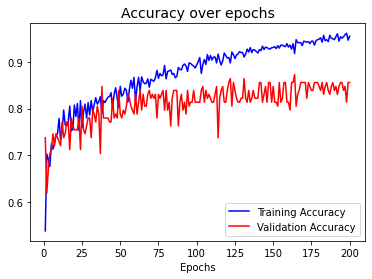

Best validation accuracy was 0.873 at epoch 164


In [276]:
# Obtain training and validation metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Accuracy over epochs
plt.plot(epochs, train_acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Print best validation accuracy and epoch
print("Best validation accuracy was %5.3f at epoch %2.f" % (np.max(val_acc), np.argmax(val_acc)+1))

The best validation accuracy was observed to be 0.873 at epoch 164. The Accuracy vs Epoch plot shows that there is overfitting observed beginning at epoch 70 because following that epoch, the validation accuracy plateaus while the training accuracy continues to increase.

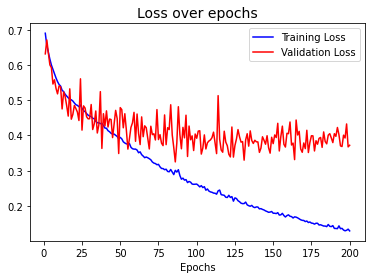

In [277]:
# Loss over epochs
plt.plot(epochs, train_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title("Loss over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

Overfitting is observed with the Loss vs Epoch plot. At around epoch 20, the validation loss begins to plateau while the training loss continues to decrease.

## Second Model

### Architecture

In [286]:
model2 = Sequential([
                    tf.keras.Input(48),
                    tf.keras.layers.Dropout(0.05),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                    ]
                   )
model2.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_23 (Dropout)        (None, 48)                0         
                                                                 
 flatten_36 (Flatten)        (None, 48)                0         
                                                                 
 dense_72 (Dense)            (None, 128)               6272      
                                                                 
 dense_73 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


As the model was overfitting, adding a dropout layer would help. A dropout layer was added before flattening to drop out observations with a rate of 0.05.

In [289]:
# Define path to store callback
cp_path = "model2.ckpt"
cp_dir = os.path.dirname(cp_path)

# Callback that saves the models weights at the best validation accuracy
cp_weights = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                       save_weights_only=False,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

# Compile model
model2.compile(optimizer = optimizers.Adam(0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

The learning rate was decreased from 0.001 to 0.0001 to slow the learning of the model, since within 50 epochs the model already began to overfit.

### Training and Validation

In [290]:
history2 = model2.fit(train_x, train_y, epochs = 200, batch_size=64, validation_data=(val_x, val_y), callbacks=[cp_weights], class_weight=class_weights, verbose=1)

Epoch 1/200
15/15 [==============================] - 2s 83ms/step - loss: 0.6942 - accuracy: 0.4319 - val_loss: 0.7038 - val_accuracy: 0.4153
Epoch 2/200
15/15 [==============================] - 1s 52ms/step - loss: 0.6906 - accuracy: 0.5106 - val_loss: 0.6921 - val_accuracy: 0.4831
Epoch 3/200
15/15 [==============================] - 1s 52ms/step - loss: 0.6879 - accuracy: 0.5638 - val_loss: 0.6820 - val_accuracy: 0.5678
Epoch 4/200
15/15 [==============================] - 1s 53ms/step - loss: 0.6844 - accuracy: 0.5851 - val_loss: 0.6791 - val_accuracy: 0.5763
Epoch 5/200
15/15 [==============================] - 1s 51ms/step - loss: 0.6779 - accuracy: 0.5819 - val_loss: 0.6743 - val_accuracy: 0.6102
Epoch 6/200
15/15 [==============================] - 1s 54ms/step - loss: 0.6796 - accuracy: 0.5968 - val_loss: 0.6720 - val_accuracy: 0.6356
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6770 - accuracy: 0.6043 - val_loss: 0.6704 - val_accuracy: 0.6271
Epoch 8

### Training Evaluation

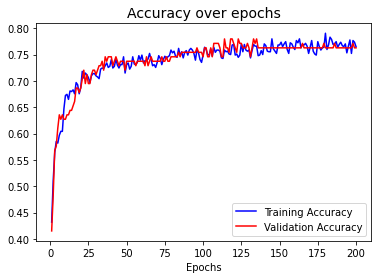

Best validation accuracy was 0.780 at epoch 114


In [291]:
# Obtain training and validation metrics
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Accuracy over epochs
plt.plot(epochs, train_acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Print best validation accuracy and epoch
print("Best validation accuracy was %5.3f at epoch %2.f" % (np.max(val_acc), np.argmax(val_acc) + 1))

The best accuracy for the validation set was 0.780 at epoch 114. This validation accuracy is worse than the first validation accuracy of 0.873 which occurred at epoch 164. It appears that the training and validation accuracy have plateaud around 0.750.

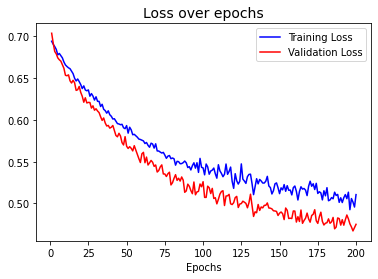

In [292]:
# Loss over epochs
plt.plot(epochs, train_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title("Loss over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

Slight underfitting is observed. Both losses are still decreasing (although validation is decreasing at a slower rate), indicating that there is underfitting and more training can be done to reach the optimum solution.

## Third Model

### Architecture

In [338]:
model3 = Sequential([
                    tf.keras.Input(48),
                    tf.keras.layers.Dropout(0.1),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                    tf.keras.layers.Dense(64, activation=tf.nn.relu),
                    tf.keras.layers.Dense(32, activation=tf.nn.relu),
                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                    ]
                   )
model3.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_31 (Dropout)        (None, 48)                0         
                                                                 
 flatten_44 (Flatten)        (None, 48)                0         
                                                                 
 dense_100 (Dense)           (None, 128)               6272      
                                                                 
 dense_101 (Dense)           (None, 64)                8256      
                                                                 
 dense_102 (Dense)           (None, 32)                2080      
                                                                 
 dense_103 (Dense)           (None, 1)                 33        
                                                                 
Total params: 16,641
Trainable params: 16,641
Non-tra

Due to some slight potential for underfitting, a third and fourth dense layer were added, with 64 and 32 hidden units. This was done to increase complexity of the model to address the slight potential for underfitting. To slightly offset the added complexity of the model, the dropout rate was increased from 0.05 to 0.1.

In [339]:
# Define path to store callback
cp_path = "model3.ckpt"
cp_dir = os.path.dirname(cp_path)

# Callback that saves the models weights at the best validation accuracy
cp_weights = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,
                                       save_weights_only=False,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

# Compile model
model3.compile(optimizer = optimizers.Adam(0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training and Validation

In [340]:
history3 = model3.fit(train_x, train_y, epochs = 200, batch_size=64, validation_data=(val_x, val_y), callbacks=[cp_weights], class_weight=class_weights, verbose=1)

Epoch 1/200
15/15 [==============================] - 4s 249ms/step - loss: 0.6954 - accuracy: 0.7840 - val_loss: 0.6715 - val_accuracy: 0.7797
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.7574 - val_loss: 0.6748 - val_accuracy: 0.7373
Epoch 3/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.7426 - val_loss: 0.6746 - val_accuracy: 0.7288
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.6968 - val_loss: 0.6776 - val_accuracy: 0.7373
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6797 - accuracy: 0.6713 - val_loss: 0.6786 - val_accuracy: 0.6949
Epoch 6/200
15/15 [==============================] - 0s 5ms/step - loss: 0.6791 - accuracy: 0.6489 - val_loss: 0.6800 - val_accuracy: 0.6610
Epoch 7/200
15/15 [==============================] - 0s 6ms/step - loss: 0.6772 - accuracy: 0.6213 - val_loss: 0.6792 - val_accuracy: 0.6695
Epoch 8/200

### Training Evaluation

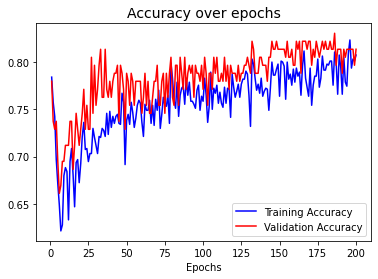

Best validation accuracy was 0.831 at epoch 186


In [341]:
# Obtain training and validation metrics
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Accuracy over epochs
plt.plot(epochs, train_acc, color='blue', label='Training Accuracy')
plt.plot(epochs, val_acc, color='red', label='Validation Accuracy')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Print best validation accuracy and epoch
print("Best validation accuracy was %5.3f at epoch %2.f" % (np.max(val_acc), np.argmax(val_acc)+1))

The best validation accuracy was 0.831 at epoch 186, which was less than the validation accuracy of the first model architecture (0.873 at epoch 164) but greater than the validation accuracy of the second model architecture (0.780 at epoch 114). The accuracies began high, most likely due to chance in the mini-batches, and then decreased within the first 5 epochs. Afterwards, the accuracies began to increase.The validation accuracy and training accuracy appear to be close together. More training time could potentially be done as the accuracies somewhat seem to have potential to continue increasing.

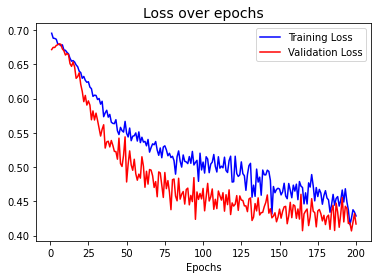

In [342]:
# Loss over epochs
plt.plot(epochs, train_loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title("Loss over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

The validation loss was consistently below the training loss. The loss in the validation seems to be around 0.40 by the end of the training, which matches that of the training loss. There could be potential for more training if there were more epochs.

## Final Model Evaluation

The best model architecture appeared to be the third model architecture. This model had the second greatest validation accuracy (0.831) as compared to the other model architectures (0.873 and 0.780, respectively). The first model architecture observed overfitting, as the validation accuracy begin to deviate from the training accuracy at around epoch 70, then the validation accuracy plateaud afterwards. The second architecture had the slight potential to train more as it was slightly underfitting, where the losses were still trending downwards. The third architecture similar accuracy and loss between the training and testing dataset, and had a lower validation loss than the second model. I believe that the third model is the best model as the first architecture had much overfitting, and the second model architecture had slight underfitting, whereas the third model improved accuracy from the second model while also retaining close accuracy and loss between the training and validation set.

### Obtain Best Model

In [344]:
# Get weights of models from epoch with best val accuracy
model.load_weights("model1.ckpt")
model2.load_weights("model2.ckpt")
model3.load_weights("model3.ckpt")

# Save models to local drive in case Google Colab crashes
!mkdir -p saved_model
model3.save('saved_model/model3')
model2.save('saved_model/model1')
model.save('saved_model/model2')

### Accuracy

In [345]:
# Get accuracy on testing set
loss, accuracy = model3.evaluate(test_x, test_y)
print('Accuracy on test dataset: %5.3f' % (accuracy))

4/4 [==============================] - 0s 9ms/step - loss: 0.4281 - accuracy: 0.8136
Accuracy on test dataset: 0.814


### Confusion Matrix

In [346]:
# Get predictions
test_pred = model3.predict(test_x)

4/4 [==============================] - 0s 3ms/step


In [348]:
# Check predictions
test_pred[0:5]

array([[0.1500526 ],
       [0.18358165],
       [0.03791126],
       [0.14376739],
       [0.8128861 ]], dtype=float32)

In [372]:
# Get confusion matrix
conf_matrix = tf.math.confusion_matrix(labels=test_y, predictions=np.rint(test_pred))
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[86, 15],
       [ 7, 10]], dtype=int32)>

### ROC

In [353]:
# Get ROC curve variables
fpr, tpr, thresh = roc_curve(test_y, test_pred)
model_auc = auc(fpr, tpr)

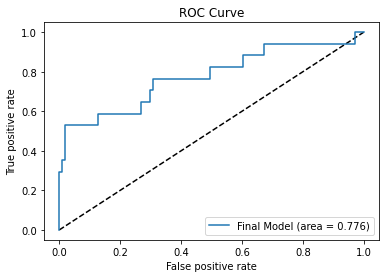

In [354]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Final Model (area = {:.3f})'.format(model_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.title('ROC Curve')
plt.show()

### Precision-Recall Curve

In [358]:
# Get precision-recall variables
precision, recall, thresholds = precision_recall_curve(test_y, test_pred)
model_auprc = auc(recall, precision)

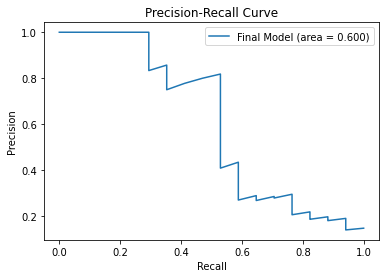

In [362]:
# Plot precision-recall curve
plt.plot(recall, precision, label='Final Model (area = {:.3f})'.format(model_auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='upper right')
plt.title('Precision-Recall Curve')
plt.show()

### F1-Score

In [365]:
# Get F1 score
f1 = f1_score(test_y, np.rint(test_pred))
print("The F1-score was %5.3f" % (f1))

The F1-score was 0.476
